<a href="https://colab.research.google.com/github/MuhammadHelmyOmar/PyTorch_Projects/blob/main/custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap

Steps to solve a machine learning problem:
1. Find a dataset
2. Turn the dataset into numbers
3. Create a model or find a pretrained one to extract the patterns in the data for prediction

# Intro

- Custom Data: a collection of data relating to your problem.
- PyTorch provides functions to load in different custom datasets in the **TorchVision**, **TorchText**, **TorchAudio**, and **TorchRec** domain libraries.
- If the previous functions are not enough, we can subclass **torch.utils.data.Dataset** and customize it to our needs.
- In this notebook, we will not use an in-built PyTorch dataset.
- We will load a custom dataset and train a model on it.



# Setting up environment

In [1]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [2]:
# Using a device-agnostic code is a best practice in DL

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Setting up Data

- Start with existing data.
- We will use a subset of the [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset.
- Food-101 splits to:
    - 1000 images of 101 different kinds of foods = 101,000 total images
    - 750,750 for training and 250,250 for testing
- Food-101 is included in PyTorch now.

## Formatting the custom data

- We will start with three food classes: Sushi, Pizza, and Steak.

### Data Creation

In [3]:
import torchvision as tv
import pathlib # Setting up data directory

tv.__version__
data_dir = pathlib.Path("../data")

In [4]:
train_data = tv.datasets.Food101(root = data_dir,
                         split = "train",
                         download = True)

test_data = tv.datasets.Food101(root = data_dir,
                                split = "test",
                                download = True)

100%|██████████| 5.00G/5.00G [02:47<00:00, 29.8MB/s]


In [5]:
train_data, test_data

(Dataset Food101
     Number of datapoints: 75750
     Root location: ../data
     split=train,
 Dataset Food101
     Number of datapoints: 25250
     Root location: ../data
     split=test)

In [6]:
class_names = train_data.classes
print(len(class_names))
class_names[:20]

101


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla']

hot_and_sour_soup


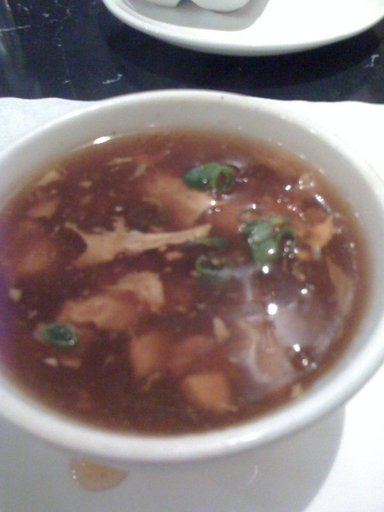

In [7]:
# View a sample image

print(class_names[train_data[1000][1]])
train_data[1000][0]

### Subseting appropriate classes

- Copy 10% random images of the specified classes to a separate folders.

In [8]:
import random

In [9]:
data_path = data_dir / "food-101" / "images"
target_classes = ["sushi", "steak", "pizza"]

DATA_AMOUNT = 0.1

def get_subset(image_path = data_path,
               data_splits = ['train', 'test'],
               target_classes = ['pizza', 'steak', 'sushi'],
               amount = 0.1,
               seed = 42):

    random.seed(seed)
    label_splits = {}

    for data_split in data_splits:

        print(f"[INFO] Creating {data_split} split..")

        label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
        with open(label_path, 'r') as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]

        # Extracting a random subset
        n_samples = round(amount * len(labels))
        print(f"[INFO] Extracting random subset of {n_samples} images for {data_split}..")
        sample_images = random.sample(labels, k = n_samples)

        # Apply full path
        image_paths = [pathlib.Path(str(image_path / sample_image) + ".jpg") for sample_image in sample_images]
        label_splits[data_split] = image_paths

    return label_splits

In [10]:
label_splits = get_subset(amount = DATA_AMOUNT)
label_splits.keys(), label_splits['test'][:14]

[INFO] Creating train split..
[INFO] Extracting random subset of 225 images for train..
[INFO] Creating test split..
[INFO] Extracting random subset of 75 images for test..


(dict_keys(['train', 'test']),
 [PosixPath('../data/food-101/images/sushi/684266.jpg'),
  PosixPath('../data/food-101/images/sushi/988559.jpg'),
  PosixPath('../data/food-101/images/sushi/1987407.jpg'),
  PosixPath('../data/food-101/images/sushi/3837522.jpg'),
  PosixPath('../data/food-101/images/sushi/887831.jpg'),
  PosixPath('../data/food-101/images/steak/966174.jpg'),
  PosixPath('../data/food-101/images/pizza/344397.jpg'),
  PosixPath('../data/food-101/images/pizza/416067.jpg'),
  PosixPath('../data/food-101/images/steak/1868005.jpg'),
  PosixPath('../data/food-101/images/pizza/714866.jpg'),
  PosixPath('../data/food-101/images/pizza/194643.jpg'),
  PosixPath('../data/food-101/images/sushi/2394442.jpg'),
  PosixPath('../data/food-101/images/sushi/1742201.jpg'),
  PosixPath('../data/food-101/images/pizza/195160.jpg')])

### Moving images to dedicated folders

In [11]:
# Create target directory path
target_dir_name = f"../data/pizz_sushi_steak_{str(int(DATA_AMOUNT*100))}_precent"
print(f"Creating directory: '{target_dir_name}'")

# Set up the directories
target_dir = pathlib.Path(target_dir_name)
# Make the directories
target_dir.mkdir(parents = True, exist_ok = True)

Creating directory: '../data/pizz_sushi_steak_10_precent'


In [12]:
import shutil # Stands for shell utilities and provides some operations on files

In [13]:
print(target_dir)

../data/pizz_sushi_steak_10_precent


In [17]:
for data_split in label_splits.keys():
    for image_path in label_splits[str(data_split)]:
        dest_dir = target_dir / data_split / image_path.parent.stem / image_path.name

        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)

        print(f"[INFO] Copying {image_path} to {dest_dir}..")
        shutil.copy2(image_path, dest_dir) # Copyting files while preserving metadata

[INFO] Copying ../data/food-101/images/pizza/3269634.jpg to ../data/pizz_sushi_steak_10_precent/train/pizza/3269634.jpg..
[INFO] Copying ../data/food-101/images/pizza/1524655.jpg to ../data/pizz_sushi_steak_10_precent/train/pizza/1524655.jpg..
[INFO] Copying ../data/food-101/images/steak/2825100.jpg to ../data/pizz_sushi_steak_10_precent/train/steak/2825100.jpg..
[INFO] Copying ../data/food-101/images/steak/225990.jpg to ../data/pizz_sushi_steak_10_precent/train/steak/225990.jpg..
[INFO] Copying ../data/food-101/images/steak/1839481.jpg to ../data/pizz_sushi_steak_10_precent/train/steak/1839481.jpg..
[INFO] Copying ../data/food-101/images/pizza/38349.jpg to ../data/pizz_sushi_steak_10_precent/train/pizza/38349.jpg..
[INFO] Copying ../data/food-101/images/pizza/3018077.jpg to ../data/pizz_sushi_steak_10_precent/train/pizza/3018077.jpg..
[INFO] Copying ../data/food-101/images/sushi/93139.jpg to ../data/pizz_sushi_steak_10_precent/train/sushi/93139.jpg..
[INFO] Copying ../data/food-101/im

In [18]:
# Trace directories

def trace_dir(dir_path):
    """
    Walk through directories printing its contents.

    Args:
        dir_path (str): target directory

    Returns:
        A print out of:
            number of subdirectories in dir_path
            number of images (files) in each subdirectory
            number of each subdirectory
    """

    import os

    for subdir_path, subdir_names, file_names in os.walk(dir_path):
        print(f"There are {len(subdir_names)} and {len(file_names)} images in '{subdir_path}'")